In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# upload index_training_modified.csv
from google.colab import files
train_index = files.upload()

In [ ]:
!pip install transformers
!pip install datasets
!pip install kmeans-pytorch
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 27.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 37.8 MB/s eta 0:00:0

In [ ]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import math
import pickle
import itertools

from transformers import AutoTokenizer, DistilBertTokenizer, DistilBertModel, DistilBertConfig
import torch.nn as nn
from datasets import load_dataset, DatasetDict, Value
from datasets import Dataset
from torch.utils.data import DataLoader
from kmeans_pytorch import kmeans, kmeans_predict

from transformers import AdamW, get_linear_schedule_with_warmup
from transformers.modeling_outputs import TokenClassifierOutput
from tqdm.notebook import tqdm
import argparse
import random

import nltk
nltk.download('all')
from nltk.corpus import wordnet as wn
import numpy as np
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

## **Preprocessing**

In [ ]:
def csv_to_df_to_dataset():
  df = pd.read_csv('index_training_modified.csv')
  # convert to ints
  map_of_scores = {'low': 0, 'medium': 1, 'high': 2}
  num_scores = [map_of_scores[x] for x in df['medium'].values]
  weights = torch.tensor([len(df['medium'].values)/3*num_scores.count(0),
                         len(df['medium'].values)/3*num_scores.count(2),
                         len(df['medium'].values)/3*num_scores.count(1)], device='cuda')
  # weights = torch.tensor([len(df['medium'].values)/num_scores.count(0),
  #                        len(df['medium'].values)/num_scores.count(2),
  #                        len(df['medium'].values)/num_scores.count(1)], device='cuda')
  print("num 0s ", num_scores.count(0))
  print("num 1s ", num_scores.count(1))
  print("num 2s ", num_scores.count(2))
  df['medium'] = num_scores
  # sensible labes
  df.rename(columns = {'medium':'labels'}, inplace = True)
  df.rename(columns = {'278.txt':'samples'}, inplace = True)
  df.rename(columns = {'P6':'prompts'}, inplace = True)
  df.rename(columns = {'DEU':'lang'}, inplace = True)

  dataset = Dataset.from_pandas(df)
  return dataset, weights

def load_and_filter(dataset, num_classes=3):
  
  def select_samples(dataset, num_classes):
    map_indexes = defaultdict(list);
    for i in range(len(dataset["labels"])):
      score = dataset["labels"][i]
      map_indexes[score].append(i);
    return map_indexes;

  def train_test_split(l1, l2):
    ind = [0] + list(itertools.accumulate(l2))
    return  [l1[ind[i]:ind[i+1]] for i in range(len(ind)-1)]
  
  map_indexes = select_samples(dataset, num_classes);
  desired = [0.65, 0.25, 0.1];
  train = [];
  val = [];
  test = [];
  for score in range(num_classes):
    now_desired = [round(x*len(map_indexes[score])) for x in desired]
    splits = train_test_split(map_indexes[score], now_desired);
    train += splits[0];
    val += splits[1];
    test += splits[2];
  random.shuffle(train); random.shuffle(val); random.shuffle(test);

  dataset = DatasetDict(
      train = dataset.select(train),
      val = dataset.select(val),
      test = dataset.select(test)
  )
  return dataset

def tokenize(dataset, batch_size):
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
  tokenized_dataset = dataset.map(
      lambda example: tokenizer(example['samples'], padding='max_length', truncation=True),
      batched=True,
      batch_size=batch_size
  )
  test_essays = tokenized_dataset['test']['samples'];
  # remove prompt data and language info so we can convert to torch tensor. or not. seemed to work fine.
  tokenized_dataset = tokenized_dataset.remove_columns(["samples", "prompts", "lang"])
  tokenized_dataset.set_format("torch")

  train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, num_workers=4, pin_memory=True);
  eval_dataloader = DataLoader(tokenized_dataset['val'], batch_size=batch_size, num_workers=4, pin_memory=True);
  test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=1)

  return train_dataloader, eval_dataloader, test_dataloader, test_essays

In [ ]:
num_classes = 3
batch_size = 16

dataset, weights = csv_to_df_to_dataset()
dataset = load_and_filter(dataset, num_classes)
train_dataloader, eval_dataloader, test_dataloader, test_essays = tokenize(dataset, batch_size)

FileNotFoundError: ignored

In [ ]:
class LDC(torch.nn.Module):
  def __init__(self,num_classes, weights): 
    super(LDC,self).__init__() 
    self.num_labels = num_classes
    self.dropout = nn.Dropout(0.2)
    self.weights = weights
    self.loss_fct = FocalLoss(alpha=self.weights)
    # Configure DistilBERT's initialization
    config = DistilBertConfig(output_hidden_states=True, dropout=0.2)

    self.model = DistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
    for name, param in list(self.model.named_parameters())[:-2]:
        param.requires_grad = False
    self.LSTM = nn.LSTM(768, 768, bias=True, bidirectional=True, batch_first=True)
    # self.LSTM.train()
    # i will also try softmax and see which is better
    self.classifier = nn.Linear(768, num_classes) # load and initialize weights
    torch.nn.init.xavier_uniform(self.classifier.weight)

  def forward(self, input_ids=None, attention_mask=None, labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state
    # print("output shape: ", outputs[0].size())
    encoder_input = sequence_output
    # print("LSTM_input:", encoder_input.size())
    LSTM_values = self.LSTM(encoder_input)
    # embedding corresponding to final hidden state
    embed = LSTM_values[1][0]
    # print("post LSTM: ", embed.size())
    # average beginning and end vectors
    embed = (torch.sum(embed, dim=0)) / 2
    # print("post sum: ", embed.size())
    ouputs = LSTM_values[0]

    logits = self.classifier(embed) # calculate losses
    target = torch.nn.functional.one_hot(labels, num_classes=self.num_labels).double()
    loss = None
    if labels is not None:
      # .view(-1, self.num_labels)
      loss = self.loss_fct(logits, target, labels)

    # return (TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions), embed, target)
    return loss, embed, outputs, logits, target

class FocalLoss(nn.Module):
  def __init__(self, gamma=2.0, alpha=None):
      super(FocalLoss, self).__init__()
      self.gamma = gamma
      self.alpha = alpha

  def forward(self, inputs, targets, labels):
      specif_alpha = torch.index_select(self.alpha, 0, labels)
      ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
      pt = torch.exp(-ce_loss)
      focal_loss = specif_alpha * (1-pt)**self.gamma * ce_loss
      return focal_loss.mean()

In [ ]:
def train_LDC(model, train_dataloader, eval_dataloader, num_epochs, num_classes):
  num_training_steps = int(num_epochs * len(train_dataloader))
  optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

  best_val_loss = float("inf")
  progress_bar = tqdm(range(num_training_steps))

  train_loss_history = [];
  val_loss_history = [];

  for epoch in range(num_epochs):
      # training
      model.train()
      train_loss = 0;
      for batch_i, batch in enumerate(train_dataloader):
          batch = {k: v.to(device) for k, v in batch.items()}
          # batch = ([text1, text2], [0, 1])
          output = model(**batch)
          loss = output[0];
          
          optimizer.zero_grad()
          train_loss += torch.sum(loss, dim=0)
          loss.backward()
          optimizer.step()
          lr_scheduler.step()
          progress_bar.update(1)

      avg_train_loss = train_loss/len(train_dataloader);
      # validation
      model.eval()
      val_loss = 0;
      for batch_i, batch in enumerate(eval_dataloader):
          batch = {k: v.to(device) for k, v in batch.items()}
          with torch.no_grad():
              output = model(**batch)
              loss = output[0];
          val_loss += torch.sum(loss, dim=0)
      
      avg_val_loss = val_loss / len(eval_dataloader)
      train_loss_history.append(avg_train_loss.cpu().item());
      val_loss_history.append(avg_val_loss.cpu().item());
      print(f"Epoch {epoch+1}" + " | " + f"Training loss: {avg_train_loss}" + " | " + f"Validation loss: {avg_val_loss}")
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
  return model, train_loss_history, val_loss_history

In [ ]:
## Evaluation ##
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import OPTICS

def run_eval(model, test_dataloader):
    # on test set ##
    model.eval()
    predictions_test = [];
    labels_test = [];
    E = []
    softmax = nn.Softmax(dim=1)
    # grads = [];
    for batch_i, batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch); 
        logits = outputs[3]; embed_x1 = outputs[1]; target = outputs[4];
        
        pred = np.argmax(softmax(logits.detach().cpu()))
        truth = np.argmax(target.detach().cpu())
        predictions_test.append(pred);
        labels_test.append(truth);
        E.append(embed_x1)

    E = torch.stack(E, dim=0);
    E = E.view(len(test_dataloader), -1).detach().cpu()

    pca = decomposition.PCA(n_components=2)
    x = torch.Tensor(pca.fit_transform(E))
    db = OPTICS().fit(x)
    clusters=x;
    return labels_test, predictions_test, clusters, db
    # , grads

def get_accuracy(actual, predicted):
    correct = 0;
    for i in range(len(actual)):
      print(predicted[i], actual[i])
      if(predicted[i] == actual[i]):
        correct += 1;
    return correct/len(actual);

def get_f1(actual, predicted, num_classes):
  f1s = [];
  for i in range(num_classes):
    tp = 0;
    fp = 0;
    fn = 0;
    for j in range(len(predicted)):
      if(predicted[j] == actual[j] and actual[j] == i):
        tp += 1;
      if(predicted[j] == i and actual[j] != i):
        fp += 1;
      if(predicted[j] != i and actual[j] == i):
        fn += 1;
    precision = tp / (tp + fp + 1)
    recall = tp / (tp + fn + 1)
    f1 = 2*precision*recall / (precision+recall+1)
    f1s.append(f1)
  return f1s;

def get_confusion(actual, predicted):
    return metrics.confusion_matrix(actual, predicted)


def run_summary(model, test_dataloader, num_classes):

   actual, predicted, clusters, db = run_eval(model, test_dataloader)
   # , grads
   accuracy = get_accuracy(actual, predicted);
   f1 = get_f1(actual, predicted, num_classes);
   confusion = get_confusion(actual, predicted)

   return accuracy, f1, confusion, clusters, db
   #, grads

def generate_figures(training_history, validation_history, confusion_matrix, clusters, db):
    x = range(len(training_history))
    fig1 = plt.figure(1);
    plt.plot(x, training_history);
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss");
    plt.title("Training History");
    
    x = range(len(validation_history))
    fig2 = plt.figure(2);
    plt.plot(x, validation_history);
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss");
    plt.title("Validation History");

    fig3 = plt.figure(3)
    ax = fig3.add_subplot(111)
    cax = ax.matshow(confusion_matrix, interpolation='nearest')
    fig3.colorbar(cax)

    fig4 = plt.figure(4);
    plt.figure(figsize=(4, 3), dpi=160)
    plt.scatter(clusters[:, 0], clusters[:, 1], c=db.labels_, cmap='cool')
    plt.axis([-1, 1, -1, 1])
    plt.tight_layout()
    plt.show()
    
    return fig1, fig2, fig3, fig4

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-42-4f917070ad8c>:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.classifier.weight)


  0%|          | 0/4030 [00:00<?, ?it/s]

Epoch 1 | Training loss: 2676804.8562200377 | Validation loss: 1964498.5020467404
Epoch 2 | Training loss: 1930083.2294661636 | Validation loss: 2028242.087855166
Epoch 3 | Training loss: 1799708.156324785 | Validation loss: 1944372.4354618287
Epoch 4 | Training loss: 1733339.8729104798 | Validation loss: 1937776.7706714012
Epoch 5 | Training loss: 1683638.758703364 | Validation loss: 1879522.0275191353
Epoch 6 | Training loss: 1638831.1034788287 | Validation loss: 1932298.54044495
Epoch 7 | Training loss: 1590320.6073727706 | Validation loss: 1884909.8222289444
Epoch 8 | Training loss: 1548269.532297841 | Validation loss: 1937529.6105211412
Epoch 9 | Training loss: 1494359.6909324424 | Validation loss: 2200076.2136808448
Epoch 10 | Training loss: 1477434.1418892322 | Validation loss: 2017818.9030433693
tensor(0) tensor(0)
tensor(2) tensor(2)
tensor(2) tensor(2)
tensor(2) tensor(1)
tensor(2) tensor(2)
tensor(1) tensor(1)
tensor(1) tensor(1)
tensor(2) tensor(2)
tensor(1) tensor(1)
tenso

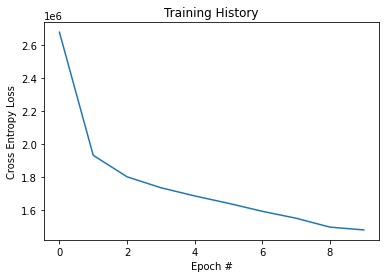

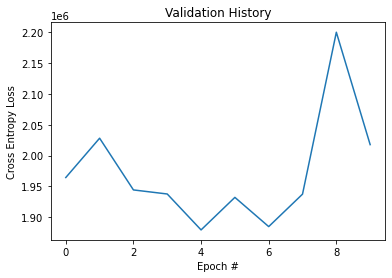

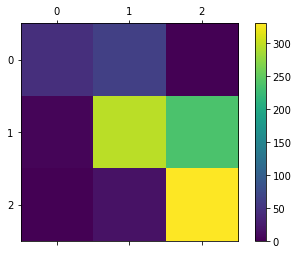

<Figure size 432x288 with 0 Axes>

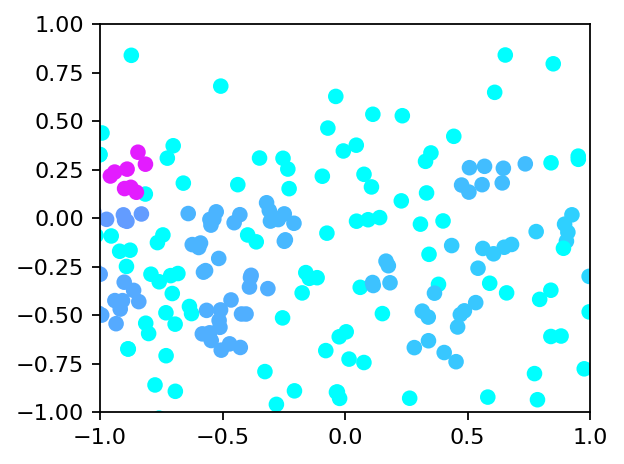

In [ ]:
num_epochs = 10;

model = LDC(num_classes, weights)
model = model.to(device)
model, train_loss_history, val_loss_history = train_LDC(model, train_dataloader, eval_dataloader, num_epochs, num_classes)
## Evaluate model ##
accuracy, f1, confusion, clusters, db = run_summary(model, test_dataloader, num_classes);
# , grads
print("Accuracy = " + str(accuracy) + " | f1 = " + str(f1));
train_fig, validation_fig, confusion_fig, clsuters_fig = generate_figures(train_loss_history, val_loss_history, confusion, clusters, db)

In [ ]:
state_dict = model.state_dict()
# Print the state dictionary

# Load prior weights

In [ ]:
state_dict = torch.load('/content/drive/MyDrive/LSTM_68.pth')

In [ ]:
keys_to_load = ['model.transformer.layer.5.output_layer_norm.bias', 'model.transformer.layer.5.output_layer_norm.weight', 'model.transformer.layer.5.ffn.lin2.bias', 'model.transformer.layer.5.ffn.lin1.weight',
                'model.transformer.layer.5.sa_layer_norm.bias', 'model.transformer.layer.5.sa_layer_norm.weight', 'model.transformer.layer.5.attention.out_lin.bias', 'model.transformer.layer.5.attention.out_lin.weight',
                'model.transformer.layer.5.attention.v_lin.bias', 'model.transformer.layer.5.attention.v_lin.weight', 'model.transformer.layer.5.attention.k_lin.bias', 'model.transformer.layer.5.attention.k_lin.weight',
                'model.transformer.layer.5.attention.q_lin.bias', 'model.transformer.layer.5.attention.q_lin.weight', 'model.transformer.layer.4.output_layer_norm.bias', 'model.transformer.layer.4.output_layer_norm.weight',
                'model.transformer.layer.4.ffn.lin2.bias', 'model.transformer.layer.4.ffn.lin2.weight', 'model.transformer.layer.4.ffn.lin1.bias', 'model.transformer.layer.4.ffn.lin1.weight', 'model.transformer.layer.4.sa_layer_norm.bias',
                'model.transformer.layer.4.sa_layer_norm.weight', 'model.transformer.layer.4.attention.out_lin.bias', 'model.transformer.layer.4.attention.out_lin.weight', 'model.transformer.layer.4.attention.v_lin.bias', 
                'model.transformer.layer.4.attention.v_lin.weight', 'model.transformer.layer.4.attention.k_lin.bias', 'model.transformer.layer.4.attention.k_lin.weight', 'model.transformer.layer.4.attention.q_lin.bias', 
                'model.transformer.layer.4.attention.q_lin.weight']

                # 'LSTM.weight_ih_l0', 'LSTM.weight_hh_l0', 'LSTM.bias_ih_l0', 'LSTM.bias_hh_l0', 'LSTM.weight_ih_l0_reverse', 'LSTM.weight_hh_l0_reverse', 'LSTM.bias_ih_l0_reverse', 'LSTM.bias_hh_l0_reverse',

filtered_weights = {k: v for k,v in state_dict.items() if k in keys_to_load}

## S2n + LSTM implementation using TOEFL weights

### Utility Functions

In [ ]:
def normalize_scores(dataset, num_classes, prompt):
  if(num_classes != None):
    s_qcut, percentiles = pd.qcut(dataset[prompt][:]['score'], q=num_classes, duplicates='drop', retbins=True)
    num_classes = len(percentiles)
    def normalize(example):
      flag = False;
      for index in range(len(percentiles)-1):
        if(example["score"] >= percentiles[index] and example["score"] < percentiles[index+1]):
          example["score"] = index
          flag=True;
      if(not flag):
        example["score"] = num_classes - 1;
      return example
    dataset = dataset.map(normalize)
  else:
    num_classes = max(dataset[prompt][:]["score"])
  return dataset, num_classes;

def select_samples_s2n(dataset_s2n, prompt, num_classes, neach):
  map_indexes = defaultdict(list);
  for i in range(len(dataset_s2n[prompt])):
    score = dataset_s2n[prompt][i]['score']
    map_indexes[score].append(i);
  return map_indexes;

def modify(text, threshold=1.0):
  words = nltk.word_tokenize(text);
  tagged = nltk.pos_tag(words)
  output = ""
  ps = PorterStemmer()
  map={'NNS':'n', 'NNPS':'n', 'NNP':'n', 'NN':'n', 'JJ':'a', 'JJR':'a', 
      'JJS':'a', 'RB':'r', 'RBR':'r', 'RBS':'r', 'WP':'r',
      'VB':'v', 'VBD':'v', 'VBG':'v', 'VBN':'v', 'VBP':'v', 'VBZ':'v'} 

  for i in range(0,len(words)):
      replacements = []
      epsilon = abs(np.random.randn())
      for syn in wn.synsets(words[i]):
          if tagged[i][1] == 'NNP' or tagged[i][1] == 'NNS' or tagged[i][1] == "NN" or tagged[i][1] == 'DT':
              break          
          word_type = tagged[i][1][0].lower(); 
          if syn.name().find("."+word_type+"."):
              if(tagged[i][1] in map.keys()):
                r = WordNetLemmatizer().lemmatize(syn.name()[0:syn.name().find(".")], map[tagged[i][1]])
              else:
                r = words[i]
              replacements.append(r)
      if len(replacements) > 0:
          replacement = replacements[random.randint(0,len(replacements)-1)] if epsilon < threshold else words[i]
          output = output + " " + replacement
      else:
          output = output + " " + words[i] if epsilon > threshold else output + " "
  return output

def augment(dataset, prompt, indexes, n_augment):
  last = len(dataset[prompt]);
  for i in range(len(indexes)):
    for j in range(n_augment):
      new_item = {'essay':modify(dataset[prompt][i]['essay']), 'score':dataset[prompt][indexes[i]]['score']};
      dataset[prompt] = dataset[prompt].add_item(new_item);
      indexes.append(last);
      last += 1;
  return dataset, indexes

def train_test_split(l1, l2):
  ind = [0] + list(itertools.accumulate(l2))
  return  [l1[ind[i]:ind[i+1]] for i in range(len(ind)-1)]

def load_and_filter(prompt, num_classes=None, neach=2, n_augment=10, split=[10, 10]):
  dataset_s2n = load_dataset("Ericwang/ASAP")
  num_classes = num_classes if num_classes != None else None
  dataset_s2n, num_classes = normalize_scores(dataset_s2n, num_classes, prompt);
  map_indexes = select_samples_s2n(dataset_s2n, prompt, num_classes, neach);

  desired = [neach, split[0], split[1]];
  train = [];
  val = [];
  test = [];
  for score in range(num_classes):
    splits = train_test_split(map_indexes[score], desired);
    train += splits[0];
    val += splits[1];
    test += splits[2];

  dataset_s2n, indexes = augment(dataset_s2n, prompt, train, n_augment);
  random.shuffle(train); random.shuffle(val); random.shuffle(test);
  dataset_s2n = DatasetDict(
      train=dataset_s2n[prompt].select(indexes),
      val=dataset_s2n[prompt].select(val),
      test=dataset_s2n[prompt].select(test),
  )
  return dataset_s2n, num_classes

## Baseline ##

In [ ]:

def train_baseline(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath, weights):
  num_training_steps = num_epochs * len(train_dataloader)
  optimizer = AdamW(model.parameters(), lr=5e-3, weight_decay=0.01)
  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
  loss_func_classification = CrossEntropyLoss(num_classes, weights)
  best_val_loss = float("inf")
  progress_bar = tqdm(range(num_training_steps))

  train_loss_history = [];
  val_loss_history = [];

  for epoch in range(num_epochs):
      # training
      model.train()
      train_loss = 0;
      for batch_i, batch in enumerate(train_dataloader):
          batch = {k: v.to(device) for k, v in batch.items()}
          out_x1, update_x1 = model(batch)
          # print("AFTER")
          # print(">>>.>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
          # print(out_x1, " ", out_x2)
          optimizer.zero_grad()
          x1_classification_val = loss_func_classification(update_x1);
          x1_classification_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights

          train_loss += x1_classification_val.item()
    
          lr_scheduler.step()
          progress_bar.update(1)
      avg_train_loss = train_loss/len(train_dataloader);
      # validation
      model.eval()
      val_loss = 0;
      for batch_i, batch in enumerate(eval_dataloader):
          batch = {k: v.to(device) for k, v in batch.items()}
          with torch.no_grad():
            out_x1, update_x1 = model(batch)
            x1_classification_val = loss_func_classification(update_x1);
          val_loss +=  x1_classification_val.item()
      
      avg_val_loss = val_loss / len(eval_dataloader)
      train_loss_history.append(avg_train_loss);
      val_loss_history.append(avg_val_loss);
      print(f"Epoch {epoch+1}" + " | " + f"Training loss: {avg_train_loss}" + " | " + f"Validation loss: {avg_val_loss}")
      if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
      best_val_loss = avg_val_loss
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': best_val_loss,
          },
          f"{dirpath}/epoch_{epoch}.pt"
          )
  return model, train_loss_history, val_loss_history



### Siamese Network ###

In [ ]:
class SiameseNetwork(nn.Module):

    def __init__(self, num_labels):
        super(SiameseNetwork, self).__init__()
        self.num_labels = num_labels;
        self.dropout = nn.Dropout(0.1) 
        self.LSTM = nn.LSTM(768, 768, bias=True, bidirectional=True)
        self.LSTM.train()
        # Configure DistilBERT's initialization
        config = DistilBertConfig(output_hidden_states=True, dropout=0.1)

        self.model = model = DistilBertModel.from_pretrained("distilbert-base-uncased", config=config)
        for name, param in list(self.model.named_parameters())[3:-3]: 
            param.requires_grad = False
        
        self.classifier = nn.Linear(768, num_labels) # load and initialize weights
        torch.nn.init.xavier_uniform_(self.classifier.weight)

    def forward_one(self, input_ids=None, attention_mask=None, labels=None):
        token_embeds = self.model.get_input_embeddings().weight[input_ids].detach().clone()
        token_embeds.requires_grad = True;
        outputs = self.model(inputs_embeds=token_embeds, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state
        # print(sequence_output.size())
        encoder_input = sequence_output[0,:,:].squeeze(0).view(-1,768)
        # print("LSTM_input:", encoder_input.size())
        LSTM_values = self.LSTM(encoder_input)
        # embedding corresponding to final hidden state
        embed = LSTM_values[1][0]
        # average beginning and end vectors
        embed = (torch.add(embed[0,:], embed[1,:]) / 2).unsqueeze(0)
        # print("embedding size:", embed.size())
        return LSTM_values[0], embed, token_embeds


    def forward(self, x1, x2=None, x3=None):
        outputs_x1, out_x1, token_embeds_x1 = self.forward_one(**x1)
        logits_x1 = self.classifier(out_x1)
        target_x1 = torch.nn.functional.one_hot(x1['labels'], num_classes=self.num_labels).double()
        args_x1 = (logits_x1, target_x1, outputs_x1, token_embeds_x1)

        if(x2 is not None):
          outputs_x2, out_x2, token_embeds_x2 = self.forward_one(**x2)
          self.dropout(out_x2)
          logits_x2 = self.classifier(out_x2);
          target_x2 = torch.nn.functional.one_hot(x2['labels'], num_classes=self.num_labels).double()
          args_x2 = (logits_x2, target_x2, outputs_x2, token_embeds_x2)
          # print(out_x1, " ", out_x2)
          if(x3 is None):
            return out_x1, out_x2, args_x1, args_x2
          else:
            outputs_x3, out_x3, token_embeds_x3 = self.forward_one(**x2)
            logits_x3 = self.classifier(out_x3);
            target_x3 = torch.nn.functional.one_hot(x3['labels'], num_classes=self.num_labels).double()
            args_x3 = (logits_x3, target_x3, outputs_x3, token_embeds_x3)
            return out_x1, out_x2, out_x3, args_x1, args_x2, args_x3
        else:
          # grad = torch.autograd.grad(logits_x1[0][0], token_embeds_x1);
          args_x1 = (logits_x1, target_x1, outputs_x1)
          return out_x1, args_x1
                                
                              
class CrossEntropyLoss(torch.nn.Module):
  def __init__(self, num_labels, weights):
    super(CrossEntropyLoss, self).__init__()  # pre 3.3 syntax
    self.num_labels = num_labels;
    self.softmax = nn.Softmax(dim=1)
    self.weights = weights
    
  def forward(self, x):
    if weights is not None:
      loss_fct = nn.CrossEntropyLoss(weights);
    loss_fct = nn.CrossEntropyLoss();
    logits = x[0]; target = x[1]; outputs = x[2];
    # print("target_x1", target.size())
    # print("logits:", logits.size())
    #print(self.softmax(logits), target)
    loss = loss_fct(logits, target)
    return loss 

class ContrastiveLoss(torch.nn.Module):
  def __init__(self, m=1):
    super(ContrastiveLoss, self).__init__()  # pre 3.3 syntax
    self.m = m  # margin or radius

  def forward(self, y1, y2, flag):
    # flag = 1 means y1 and y2 are supposed to be same
    # flag = 0 means y1 and y2 are supposed to be different
    #(torch.norm(y1, 1) + torch.norm(y2, 1)) / 2
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    euc_dist = cos(y1, y2)
    loss = torch.mean(flag * torch.pow(euc_dist, 2) + (1-flag) * torch.pow(torch.clamp(self.m - euc_dist, min=0.0), 2))
    return loss 
  
class TripletLoss(torch.nn.Module):
    def __init__(self, m=1.0):
      super(TripletLoss, self).__init__()  # pre 3.3 syntax
      self.m = m  # margin or radius
    def forward(self, anchor, positive, negative):
      triplet_loss = nn.TripletMarginLoss(margin=self.m, p=2)
      loss = triplet_loss(anchor, positive, negative)
      return loss 
        

In [ ]:
import os 
import shutil 

def train_siamese(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath, weights=None):
  # be sure to swap which loss function you use.
  loss_func = ContrastiveLoss()
  loss_func_classification = CrossEntropyLoss(num_classes, weights)

  num_training_steps = num_epochs * len(train_dataloader)
  optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

  best_val_loss = float("inf")
  progress_bar = tqdm(range(num_training_steps))

  train_loss_history = [];
  val_loss_history = [];
  alpha, beta, gamma = 1, 1, 1;
  i = 0
  for epoch in range(num_epochs):
      print(f"Iteration {i+1}: {torch.cuda.max_memory_allocated()/(1024**2):.2f} MB")
      # training
      model.train()
      train_loss = 0;
      for (sample1, sample2) in train_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          sample2 = {k: v.to(device) for k, v in sample2.items()}
          # batch = ([text1, text2], [0, 1])
          out_x1, out_x2, update_x1, update_x2 = model(sample1, sample2)
          # print("AFTER")
          # print(">>>.>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
          # print(out_x1, " ", out_x2)
          optimizer.zero_grad()
          flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item();
          # print(out_x1, " p3n1s ", out_x2)
          # loss_val = gamma*loss_func(out_x1, out_x2, flag)
          # loss_val.backward(retain_graph=True)         # compute grads
          # optimizer.step()            # update weights
          loss_val = torch.Tensor([0])

          x1_classification_val = alpha*loss_func_classification(update_x1);
          x1_classification_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights

          x2_classification_val = beta*loss_func_classification(update_x2);
          x2_classification_val.backward()         # compute grads
          optimizer.step()  

          train_loss += x1_classification_val.item() + x2_classification_val.item() + loss_val.item()
    
          lr_scheduler.step()
          progress_bar.update(1)
      avg_train_loss = train_loss/len(train_dataloader);

      # validation
      model.eval()
      val_loss = 0;
      for (sample1, sample2) in eval_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          sample2 = {k: v.to(device) for k, v in sample2.items()}
          flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item()
          with torch.no_grad():
                out_x1, out_x2, update_x1, update_x2 = model(sample1, sample2)
                x1_classification_val = loss_func_classification(update_x1);
                x2_classification_val = loss_func_classification(update_x2);
                # loss_val = loss_func(out_x1, out_x2, flag)
                loss_val = torch.Tensor([0])
          val_loss +=  x1_classification_val.item() + x2_classification_val.item() +loss_val.item();

      avg_val_loss = val_loss / len(eval_dataloader)
      train_loss_history.append(avg_train_loss);
      val_loss_history.append(avg_val_loss);
      print(f"Epoch {epoch+1}" + " | " + f"Training loss: {avg_train_loss}" + " | " + f"Validation loss: {avg_val_loss}")
      if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
      best_val_loss = avg_val_loss
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': best_val_loss,
          },
          f"{dirpath}/epoch_{epoch}.pt"
          )
  return model, train_loss_history, val_loss_history
        

In [ ]:
## MODIFIED ## 9.56

import os 
import shutil 

def train_siamese_triplet(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath, weights):
  loss_func = TripletLoss()
  loss_func_classification = CrossEntropyLoss(num_classes, weights)

  num_training_steps = num_epochs * len(train_dataloader)
  optimizer = AdamW(model.parameters(), lr=5e-3, weight_decay=0.1)
  lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

  best_val_loss = float("inf")
  progress_bar = tqdm(range(num_training_steps))

  train_loss_history = [];
  val_loss_history = [];
  alpha, beta, gamma = 1, 1, 1;
  for epoch in range(num_epochs):
      # training
      model.train()
      train_loss = 0;
      for (sample1, sample2, sample3) in train_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          sample2 = {k: v.to(device) for k, v in sample2.items()}
          sample3 = {k: v.to(device) for k, v in sample2.items()}
          # batch = ([text1, text2], [0, 1])
          out_x1, out_x2, out_x3, update_x1, update_x2, update_x3 = model(sample1, sample2, sample3)
          
          optimizer.zero_grad()
          flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item();
          
          loss_val = gamma*loss_func(out_x1, out_x2, out_x3)
          loss_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights

          x1_classification_val = alpha*loss_func_classification(update_x1);
          x1_classification_val.backward(retain_graph=True)         # compute grads
          optimizer.step()            # update weights

          train_loss += loss_val.item() + x1_classification_val.item() 
    
          lr_scheduler.step()
          progress_bar.update(1)

      avg_train_loss = train_loss/len(train_dataloader);

      # validation
      model.eval()
      val_loss = 0;
      for (sample1, sample2, sample3) in eval_dataloader:
          sample1 = {k: v.to(device) for k, v in sample1.items()}
          sample2 = {k: v.to(device) for k, v in sample2.items()}
          sample3 = {k: v.to(device) for k, v in sample3.items()}
          flag = sample1['labels'] == sample2['labels']; flag = flag.cpu().item()
          with torch.no_grad():
                out_x1, out_x2, out_x3, update_x1, update_x2, update_x3 = model(sample1, sample2, sample3)
                x1_classification_val = loss_func_classification(update_x1);
                loss_val = loss_func(out_x1, out_x2, out_x3) 
          val_loss +=  loss_val.item() + x1_classification_val.item() 

      avg_val_loss = val_loss / len(eval_dataloader)
      train_loss_history.append(avg_train_loss);
      val_loss_history.append(avg_val_loss);
      print(f"Epoch {epoch+1}" + " | " + f"Training loss: {avg_train_loss}" + " | " + f"Validation loss: {avg_val_loss}")
      if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
      best_val_loss = avg_val_loss
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'val_loss': best_val_loss,
          },
          f"{dirpath}/epoch_{epoch}.pt"
          )
  return model, train_loss_history, val_loss_history
        

In [ ]:
def tokenize(dataset, batch_size):
  tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
  tokenized_dataset = dataset.map(
      lambda example: tokenizer(example['essay'], padding='max_length', truncation=True),
      batched=True,
      batch_size=batch_size
  )
  essays = tokenized_dataset['test']['essay'];
  tokenized_dataset = tokenized_dataset.remove_columns(["essay"])
  tokenized_dataset = tokenized_dataset.rename_column("score", "labels")
  tokenized_dataset.set_format("torch")

  train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, num_workers=4, pin_memory=True);
  eval_dataloader = DataLoader(tokenized_dataset['val'], batch_size=batch_size, num_workers=4, pin_memory=True);
  test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=1)

  return train_dataloader, eval_dataloader, test_dataloader, essays

In [ ]:
def gen_data(prompt, num_classes, n_each, n_augment, flag, split):
  counts = defaultdict(int);
  dataset, num_classes = load_and_filter(prompt, num_classes, n_each, n_augment, split);
  batch_size = 1
  train_dataloader, eval_dataloader, test_dataloader, essays = tokenize(dataset, batch_size);

  count_train = 0
  batches_train = []
  for batch_i, batch in enumerate(train_dataloader):
    count_train += 1
    batches_train.append(batch);
  print(count_train)

  ct_eval = 0
  batches_eval = [];
  for batch_i, batch in enumerate(eval_dataloader):
    ct_eval += 1
    batches_eval.append(batch);
  print(ct_eval)

  ct_test = 0
  batches_test = [];
  for batch_i, batch in enumerate(test_dataloader):
    ct_test += 1
    batches_test.append(batch)
  print(ct_test)

  if flag == 0:
    return num_classes, counts, train_dataloader, eval_dataloader, test_dataloader, essays

  if(flag == 1):
    train_dataloader = list(itertools.combinations(batches_train, 2)); 
    eval_dataloader = list(itertools.combinations(batches_eval, 2)); 
  if (flag == 2):
    train_dataloader = list(itertools.combinations(batches_train, 3))
    train_dataloader = [(x,y,z) for (x,y,z) in train_dataloader if x['labels'] == y['labels'] and x['labels'] != z['labels']]

    eval_dataloader = list(itertools.combinations(batches_eval, 3))
    eval_dataloader = [(x,y,z) for (x,y,z) in eval_dataloader if x['labels'] == y['labels'] and x['labels'] != z['labels']]

  for batch in batches_test:
    counts[batch['labels'].item()]+=1

  for batch in batches_test:
    counts[batch['labels'].item()]+=1
  return num_classes, counts, train_dataloader, eval_dataloader, test_dataloader, essays

### Evaluation ###

In [ ]:
## Evaluation ##
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import OPTICS

def run_eval(model, test_dataloader, flag):
    # on test set ##
    model.eval()
    predictions_test = [];
    labels_test = [];
    E = []
    softmax = nn.Softmax(dim=1)
    i = 0
    # grads = [];
    print(f"Iteration {i+1}: {torch.cuda.max_memory_allocated()/(1024**2):.2f} MB")
    for batch_i, batch in enumerate(test_dataloader):
        with torch.no_grad():
          batch = {k: v.to(device) for k, v in batch.items()}
      
          if(flag == 2):
            embed_x1, update_x1= model(batch, None)
            logits = update_x1[0]; target = update_x1[1];
            # grad = update_x1[3][0].detach().cpu().numpy()
            # grads.append(grad)
          else:
            outputs = model(**batch); 
            logits = outputs[0]['logits']; embed_x1 = outputs[1]; target = outputs[2];
          
          pred = np.argmax(softmax(logits.detach().cpu()))
          truth = np.argmax(target.detach().cpu())
          predictions_test.append(pred);
          labels_test.append(truth);
          E.append(embed_x1)

    E = torch.stack(E, dim=0);
    E = E.view(len(test_dataloader), -1).detach().cpu()

    pca = decomposition.PCA(n_components=2)
    x = torch.Tensor(pca.fit_transform(E))
    db = OPTICS().fit(x)
    clusters=x;
    return labels_test, predictions_test, clusters, db
    # , grads

def get_accuracy(actual, predicted):
    correct = 0;
    for i in range(len(actual)):
      print(predicted[i], actual[i])
      if(predicted[i] == actual[i]):
        correct += 1;
    return correct/len(actual);

def get_f1(actual, predicted, num_classes):
  f1s = [];
  for i in range(num_classes):
    tp = 0;
    fp = 0;
    fn = 0;
    for j in range(len(predicted)):
      if(predicted[j] == actual[j] and actual[j] == i):
        tp += 1;
      if(predicted[j] == i and actual[j] != i):
        fp += 1;
      if(predicted[j] != i and actual[j] == i):
        fn += 1;
    precision = tp / (tp + fp + 1)
    recall = tp / (tp + fn + 1)
    f1 = 2*precision*recall / (precision+recall+1)
    f1s.append(f1)
  return f1s;

def get_confusion(actual, predicted):
    return metrics.confusion_matrix(actual, predicted)


def run_summary(model, test_dataloader, num_classes, flag):

   actual, predicted, clusters, db = run_eval(model, test_dataloader, flag)
   # , grads
   accuracy = get_accuracy(actual, predicted);
   f1 = get_f1(actual, predicted, num_classes);
   confusion = get_confusion(actual, predicted)

   return accuracy, f1, confusion, clusters, db
   #, grads

def generate_figures(training_history, validation_history, confusion_matrix, clusters, db):
    x = range(len(training_history))
    fig1 = plt.figure(1);
    plt.plot(x, training_history);
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss");
    plt.title("Training History");
    
    x = range(len(validation_history))
    fig2 = plt.figure(2);
    plt.plot(x, validation_history);
    plt.xlabel("Epoch #")
    plt.ylabel("Cross Entropy Loss");
    plt.title("Validation History");

    fig3 = plt.figure(3)
    ax = fig3.add_subplot(111)
    cax = ax.matshow(confusion_matrix, interpolation='nearest')
    fig3.colorbar(cax)

    fig4 = plt.figure(4);
    plt.figure(figsize=(4, 3), dpi=160)
    plt.scatter(clusters[:, 0], clusters[:, 1], c=db.labels_, cmap='cool')
    plt.axis([-1, 1, -1, 1])
    plt.tight_layout()
    plt.show()
    
    return fig1, fig2, fig3, fig4

## Run Main ##

  0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

10
10
243

Target number of classes = 5
dict_items([(0, 100), (2, 100), (3, 100), (1, 100), (4, 86)])
tensor([0.9720, 0.9720, 0.9720, 0.9720, 1.1302], device='cuda:0')



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to

  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 | Training loss: 4.728344221484024 | Validation loss: 8.562585386369998
Saving checkpoint!
Epoch 2 | Training loss: 6.031960231917245 | Validation loss: 4.320342796544234
Saving checkpoint!
Epoch 3 | Training loss: 3.454162908451898 | Validation loss: 4.5259091928601265
Epoch 4 | Training loss: 3.6270076504775455 | Validation loss: 4.385417195657889
Saving checkpoint!
Epoch 5 | Training loss: 3.1827928764479503 | Validation loss: 4.19876251121362
Saving checkpoint!
Epoch 6 | Training loss: 2.982045646224703 | Validation loss: 3.9442487259705863
Saving checkpoint!
Epoch 7 | Training loss: 2.8645023831299374 | Validation loss: 3.844630981485049
Saving checkpoint!
Epoch 8 | Training loss: 2.576324624674661 | Validation loss: 3.8185943017403283
Saving checkpoint!
Epoch 9 | Training loss: 2.4056534809725627 | Validation loss: 3.760638192296028
Saving checkpoint!
Epoch 10 | Training loss: 2.2606328342642104 | Validation loss: 3.71050792435805
Saving checkpoint!
Iteration 1: 2756.59 M

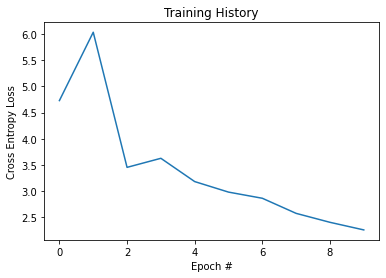

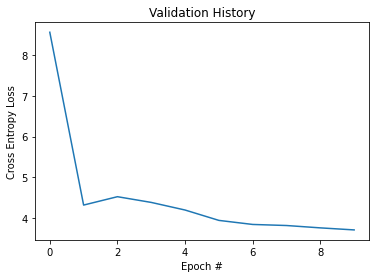

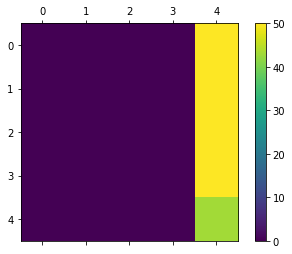

<Figure size 432x288 with 0 Axes>

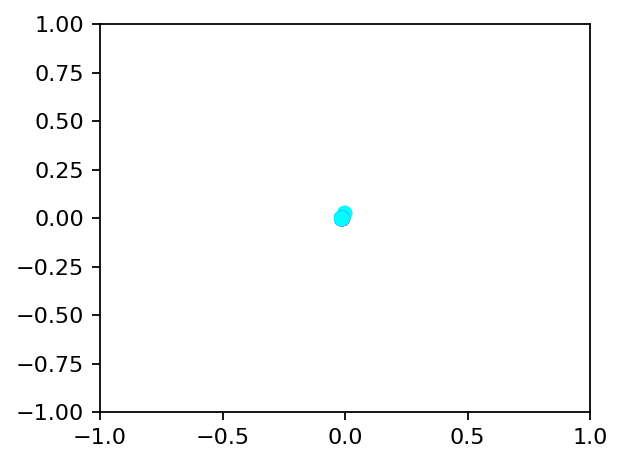

In [ ]:
# Generate data #
prompt = '1';
num_classes = 5;
n_augment = 0;
n_each = 2;
flag = 2;
splits = [n_each, 50]
num_classes, counts, train_dataloader, eval_dataloader, test_dataloader, essays = gen_data(prompt, num_classes, n_each, n_augment, flag, splits)
print("")
print("Target number of classes =", num_classes);
print(counts.items())
value_sum = sum(counts.values())
weights = torch.tensor([(value_sum/(num_classes*v)) for k,v in counts.items()], device='cuda')
# temp = weights[2]
# weights[2] = weights[1]
# weights[1] = 5*temp
print(weights)
print("")



## Define and load pretrained model ##
model = SiameseNetwork(num_classes)
# model.load_state_dict(filtered_weights, strict=False)
model = model.to(device)

## Train model ##
num_epochs = 10;
dirpath = '/content/'
model, train_loss_history, val_loss_history = train_siamese_triplet(model, train_dataloader, eval_dataloader, num_epochs, num_classes, dirpath, weights)

## Evaluate model ##
accuracy, f1, confusion, clusters, db = run_summary(model, test_dataloader, num_classes, flag);
# , grads
print("Accuracy = " + str(accuracy) + " | f1 = " + str(f1));
train_fig, validation_fig, confusion_fig, clsuters_fig = generate_figures(train_loss_history, val_loss_history, confusion, clusters, db)

In [ ]:
import gc
del eval_dataloader
gc.collect()

1367

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

NameError: ignored

In [ ]:
## Evaluate model ##
accuracy, f1, confusion, clusters, db = run_summary(model, test_dataloader, num_classes, flag);
# , grads
print("Accuracy = " + str(accuracy) + " | f1 = " + str(f1));
train_fig, validation_fig, confusion_fig, clsuters_fig = generate_figures(train_loss_history, val_loss_history, confusion, clusters, db)

Iteration 1: 13885.29 MB


RuntimeError: ignored

In [ ]:
exp_meta = dict();
exp_meta['results'] = {'testing': {'labels':labels_test, "predictions": predictions_test}, 
                    'training':train_loss_history, 'validation':val_loss_history}
exp_meta['data'] = {'prompt':prompt}
exp_meta['training_params'] = {'num_epochs':num_epochs, 'num_classes':num_classes}

with open(dirpath + '/' + exp_name + '.pickle', 'wb') as handle:
    pickle.dump(exp_meta, handle)